In [ ]:
# Cell 1: Load Saved Data
import pandas as pd
import numpy as np
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = os.path.join('..', 'data')

with open(os.path.join(DATA_DIR, 'price_data.pkl'), 'rb') as f:
    price_data = pickle.load(f)

with open(os.path.join(DATA_DIR, 'financial_data.pkl'), 'rb') as f:
    financial_data = pickle.load(f)

with open(os.path.join(DATA_DIR, 'tickers.pkl'), 'rb') as f:
    tickers = pickle.load(f)

# Load sector data
try:
    with open(os.path.join(DATA_DIR, 'sector_data.pkl'), 'rb') as f:
        sector_data = pickle.load(f)
    print(f'Loaded sector data for {len(sector_data)} companies')
except FileNotFoundError:
    sector_data = {}
    print('sector_data.pkl not found (run 01d)')

# Load macro data
try:
    with open(os.path.join(DATA_DIR, 'macro_data.pkl'), 'rb') as f:
        macro_data = pickle.load(f)
    print(f'Loaded {len(macro_data)} macro indicators: {list(macro_data.keys())}')
except FileNotFoundError:
    macro_data = {}
    print('macro_data.pkl not found (run 01e)')

# Load SPY benchmark data (run scripts/download_spy.py first)
spy_prices = None
try:
    with open(os.path.join(DATA_DIR, 'spy_prices.pkl'), 'rb') as f:
        spy_prices = pickle.load(f)
    print(f'Loaded SPY benchmark: {len(spy_prices)} days '
          f'({spy_prices.index.min().date()} to {spy_prices.index.max().date()})')
except FileNotFoundError:
    print('spy_prices.pkl not found (run scripts/download_spy.py)')

print(f'\nLoaded {len(price_data)} price datasets')
print(f'Loaded {len(financial_data)} financial datasets')
print(f'Tickers: {len(tickers)}')

# Show price data range
sample_prices = list(price_data.values())[0]
print(f'Price date range: {sample_prices.index.min()} to {sample_prices.index.max()}')

# Show available metrics for first company
sample = financial_data[0]
print(f'\nSample: {sample["ticker"]}')
print(f'Income metrics: {list(sample["quarterly_income"].index)}')
print(f'Balance metrics: {list(sample["quarterly_balance"].index)}')
print(f'Quarters: {sample["quarterly_income"].shape[1]}')


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded sector data for 505 companies
Loaded 5 macro indicators: ['GS10', 'VIXCLS', 'UNRATE', 'GDP', 'CPIAUCSL']
Loaded SPY benchmark: 4563 days (2008-01-02 to 2026-02-20)

Loaded 502 price datasets
Loaded 46 financial datasets
Tickers: 46
Price date range: 2009-01-02 00:00:00 to 2026-02-13 00:00:00

Sample: AAPL
Income metrics: ['Total Revenue', 'Cost of Revenue', 'Gross Profit', 'Operating Income', 'Net Income', 'EPS Basic', 'EPS Diluted', 'R&D Expense', 'SGA Expense', 'Interest Expense', 'Income Tax']
Balance metrics: ['Total Assets', 'Current Assets', 'Total Liabilities', 'Current Liabilities', 'Long Term Debt', 'Short Term Debt', 'Stockholders Equity', 'Cash', 'Shares Outstanding', 'Operating Cash Flow', 'Capital Expenditures']
Quarters: 53


In [8]:
# Cell 2: Feature Engineering Function

def safe_loc(df, metric, quarter):
    """Safely get value from DataFrame using .loc[metric, quarter]."""
    try:
        if metric in df.index and quarter in df.columns:
            val = df.loc[metric, quarter]
            if pd.notna(val):
                return float(val)
    except:
        pass
    return np.nan

def safe_divide(a, b):
    """Safely divide, returning NaN for zero/NaN denominators."""
    if pd.isna(a) or pd.isna(b) or b == 0:
        return np.nan
    return a / b

def safe_growth(current, previous):
    """Calculate growth rate, returning NaN if either value is missing."""
    if pd.isna(current) or pd.isna(previous) or previous == 0:
        return np.nan
    return (current - previous) / abs(previous)

def create_features(financial_data, price_data, sector_data, macro_data, spy_prices=None):
    """Create ML features from SEC financial data, stock prices, sectors, macro, and benchmark."""
    all_samples = []
    skipped = {'no_revenue': 0, 'no_price': 0, 'no_future_price': 0}
    benchmark_hits = 0

    # Prepare SPY benchmark
    spy_close = None
    if spy_prices is not None:
        if 'Adj Close' in spy_prices.columns:
            spy_close = spy_prices['Adj Close']
        elif 'Close' in spy_prices.columns:
            spy_close = spy_prices['Close']
        # Strip timezone if present
        if spy_close is not None and spy_close.index.tz is not None:
            spy_close.index = spy_close.index.tz_localize(None)

    for company in financial_data:
        ticker = company['ticker']
        income = company.get('quarterly_income')
        balance = company.get('quarterly_balance')

        if income is None or income.empty:
            continue
        if ticker not in price_data:
            continue

        ticker_prices = price_data[ticker]
        # Handle both 'Adj Close' and 'Close' column names
        if 'Adj Close' in ticker_prices.columns:
            adj_close = ticker_prices['Adj Close']
        elif 'Close' in ticker_prices.columns:
            adj_close = ticker_prices['Close']
        else:
            continue

        quarters = list(income.columns)

        # Get sector info for this ticker
        sector_info = sector_data.get(ticker, {})
        sector = sector_info.get('sector', 'Unknown')

        for i in range(len(quarters) - 1):
            q = quarters[i]
            q_prev = quarters[i + 1]

            # === Raw metrics from income statement ===
            revenue = safe_loc(income, 'Total Revenue', q)
            cost_of_rev = safe_loc(income, 'Cost of Revenue', q)
            gross_profit = safe_loc(income, 'Gross Profit', q)
            operating_income = safe_loc(income, 'Operating Income', q)
            net_income = safe_loc(income, 'Net Income', q)
            eps_basic = safe_loc(income, 'EPS Basic', q)
            eps_diluted = safe_loc(income, 'EPS Diluted', q)
            rd_expense = safe_loc(income, 'R&D Expense', q)
            sga_expense = safe_loc(income, 'SGA Expense', q)
            interest_expense = safe_loc(income, 'Interest Expense', q)
            income_tax = safe_loc(income, 'Income Tax', q)

            # Previous quarter for growth
            prev_revenue = safe_loc(income, 'Total Revenue', q_prev)
            prev_net_income = safe_loc(income, 'Net Income', q_prev)
            prev_operating_income = safe_loc(income, 'Operating Income', q_prev)
            prev_eps = safe_loc(income, 'EPS Diluted', q_prev)

            # Skip if no revenue
            if pd.isna(revenue) or revenue == 0:
                skipped['no_revenue'] += 1
                continue

            # === Raw metrics from balance sheet / cash flow ===
            total_assets = safe_loc(balance, 'Total Assets', q) if balance is not None else np.nan
            current_assets = safe_loc(balance, 'Current Assets', q) if balance is not None else np.nan
            total_liabilities = safe_loc(balance, 'Total Liabilities', q) if balance is not None else np.nan
            current_liabilities = safe_loc(balance, 'Current Liabilities', q) if balance is not None else np.nan
            long_term_debt = safe_loc(balance, 'Long Term Debt', q) if balance is not None else np.nan
            short_term_debt = safe_loc(balance, 'Short Term Debt', q) if balance is not None else np.nan
            equity = safe_loc(balance, 'Stockholders Equity', q) if balance is not None else np.nan
            cash = safe_loc(balance, 'Cash', q) if balance is not None else np.nan
            shares_out = safe_loc(balance, 'Shares Outstanding', q) if balance is not None else np.nan
            op_cash_flow = safe_loc(balance, 'Operating Cash Flow', q) if balance is not None else np.nan
            capex = safe_loc(balance, 'Capital Expenditures', q) if balance is not None else np.nan

            # Total debt
            total_debt = np.nan
            if pd.notna(long_term_debt) and pd.notna(short_term_debt):
                total_debt = long_term_debt + short_term_debt
            elif pd.notna(long_term_debt):
                total_debt = long_term_debt

            # Free cash flow
            free_cash_flow = np.nan
            if pd.notna(op_cash_flow) and pd.notna(capex):
                free_cash_flow = op_cash_flow - capex

            # === Match stock prices ===
            quarter_end = pd.Timestamp(q)

            mask = (adj_close.index >= quarter_end - pd.Timedelta(days=7)) & \
                   (adj_close.index <= quarter_end + pd.Timedelta(days=7))
            if not mask.any():
                skipped['no_price'] += 1
                continue
            quarter_price = float(adj_close[mask].iloc[0])

            future_date = quarter_end + pd.Timedelta(days=90)
            mask_future = (adj_close.index >= future_date - pd.Timedelta(days=7)) & \
                          (adj_close.index <= future_date + pd.Timedelta(days=7))
            if not mask_future.any():
                skipped['no_future_price'] += 1
                continue
            future_price = float(adj_close[mask_future].iloc[0])

            target_return = (future_price - quarter_price) / quarter_price

            # === S&P 500 benchmark return for same period ===
            benchmark_return = np.nan
            if spy_close is not None:
                spy_mask = (spy_close.index >= quarter_end - pd.Timedelta(days=7)) & \
                           (spy_close.index <= quarter_end + pd.Timedelta(days=7))
                spy_future_mask = (spy_close.index >= future_date - pd.Timedelta(days=7)) & \
                                  (spy_close.index <= future_date + pd.Timedelta(days=7))
                if spy_mask.any() and spy_future_mask.any():
                    spy_q_price = float(spy_close[spy_mask].iloc[0])
                    spy_f_price = float(spy_close[spy_future_mask].iloc[0])
                    benchmark_return = (spy_f_price - spy_q_price) / spy_q_price
                    benchmark_hits += 1

            excess_return = target_return - benchmark_return if pd.notna(benchmark_return) else np.nan

            # === Compute derived features ===
            market_cap = shares_out * quarter_price if pd.notna(shares_out) else np.nan

            # === Technical indicators from price data ===
            price_window = adj_close[adj_close.index <= quarter_end]
            ma_50 = price_window.tail(50).mean() if len(price_window) >= 50 else np.nan
            ma_200 = price_window.tail(200).mean() if len(price_window) >= 200 else np.nan
            ma_50_ratio = safe_divide(quarter_price, ma_50)
            ma_200_ratio = safe_divide(quarter_price, ma_200)

            # 3-month momentum
            momentum_date = quarter_end - pd.Timedelta(days=90)
            mask_mom = (adj_close.index >= momentum_date - pd.Timedelta(days=7)) & \
                       (adj_close.index <= momentum_date + pd.Timedelta(days=7))
            if mask_mom.any():
                past_price = float(adj_close[mask_mom].iloc[0])
                momentum_3m = (quarter_price - past_price) / past_price
            else:
                momentum_3m = np.nan

            # Volatility (60-day rolling std of daily returns)
            if len(price_window) >= 60:
                daily_returns = price_window.tail(60).pct_change().dropna()
                volatility = daily_returns.std() * np.sqrt(252)  # annualized
            else:
                volatility = np.nan

            # === Macro features ===
            gs10 = np.nan
            vix = np.nan
            unemployment = np.nan
            gdp = np.nan
            cpi = np.nan
            if macro_data:
                if 'GS10' in macro_data:
                    gs10 = macro_data['GS10'].asof(quarter_end)
                if 'VIXCLS' in macro_data:
                    vix = macro_data['VIXCLS'].asof(quarter_end)
                if 'UNRATE' in macro_data:
                    unemployment = macro_data['UNRATE'].asof(quarter_end)
                if 'GDP' in macro_data:
                    gdp = macro_data['GDP'].asof(quarter_end)
                if 'CPIAUCSL' in macro_data:
                    cpi = macro_data['CPIAUCSL'].asof(quarter_end)

            sample = {
                'ticker': ticker,
                'date': q,
                'sector': sector,
                # Price
                'quarter_price': quarter_price,
                # Profitability ratios
                'revenue': revenue,
                'revenue_growth': safe_growth(revenue, prev_revenue),
                'gross_margin': safe_divide(gross_profit, revenue),
                'profit_margin': safe_divide(net_income, revenue),
                'operating_margin': safe_divide(operating_income, revenue),
                'net_income': net_income,
                'net_income_growth': safe_growth(net_income, prev_net_income),
                'operating_income_growth': safe_growth(operating_income, prev_operating_income),
                # Per-share
                'eps_diluted': eps_diluted,
                'eps_growth': safe_growth(eps_diluted, prev_eps),
                # Expense ratios
                'rd_ratio': safe_divide(rd_expense, revenue),
                'sga_ratio': safe_divide(sga_expense, revenue),
                'tax_rate': safe_divide(income_tax, operating_income),
                # Balance sheet ratios
                'total_assets': total_assets,
                'debt_to_assets': safe_divide(total_debt, total_assets),
                'debt_to_equity': safe_divide(total_debt, equity),
                'current_ratio': safe_divide(current_assets, current_liabilities),
                'cash_ratio': safe_divide(cash, current_liabilities),
                'equity_ratio': safe_divide(equity, total_assets),
                # Returns on capital
                'roa': safe_divide(net_income, total_assets),
                'roe': safe_divide(net_income, equity),
                # Efficiency
                'asset_turnover': safe_divide(revenue, total_assets),
                'interest_coverage': safe_divide(operating_income, interest_expense),
                # Cash flow
                'operating_cash_flow': op_cash_flow,
                'free_cash_flow': free_cash_flow,
                'fcf_margin': safe_divide(free_cash_flow, revenue),
                # Valuation
                'market_cap': market_cap,
                'pe_ratio': safe_divide(quarter_price, eps_diluted) if pd.notna(eps_diluted) and eps_diluted > 0 else np.nan,
                'price_to_book': safe_divide(market_cap, equity),
                # Technical indicators
                'ma_50_ratio': ma_50_ratio,
                'ma_200_ratio': ma_200_ratio,
                'momentum_3m': momentum_3m,
                'volatility': volatility,
                # Macro indicators
                'gs10': gs10,
                'vix': vix,
                'unemployment': unemployment,
                'gdp': gdp,
                'cpi': cpi,
                # Benchmark and targets
                'benchmark_return': benchmark_return,
                'target_excess_return': excess_return,
                'target_return': target_return,
            }
            all_samples.append(sample)

    print(f'Skipped: {skipped}')
    if spy_close is not None:
        print(f'Benchmark returns matched: {benchmark_hits} samples')
    return pd.DataFrame(all_samples)

print('Feature engineering function defined (with excess returns)')

Feature engineering function defined (with excess returns)


In [9]:
# Cell 3: Create Feature Dataset
print('Creating feature dataset...')

dataset = create_features(financial_data, price_data, sector_data, macro_data, spy_prices)

print(f'\nCreated dataset with {len(dataset)} samples')
print(f'Dataset shape: {dataset.shape}')

# Count feature columns (exclude metadata and targets)
meta_cols = ['ticker', 'date', 'sector', 'target_return', 'target_excess_return', 'benchmark_return']
feature_cols = [c for c in dataset.columns if c not in meta_cols]
print(f'Features: {len(feature_cols)}')
print(f'\nCompanies: {dataset["ticker"].nunique()}')

# Show excess return stats
if 'target_excess_return' in dataset.columns and dataset['target_excess_return'].notna().any():
    print(f'\n--- Return Statistics ---')
    print(f'Raw return:    mean={dataset["target_return"].mean():.4f}, std={dataset["target_return"].std():.4f}')
    excess = dataset['target_excess_return'].dropna()
    print(f'Excess return: mean={excess.mean():.4f}, std={excess.std():.4f}')
    print(f'Benchmark:     mean={dataset["benchmark_return"].dropna().mean():.4f}')
    print(f'Excess return coverage: {len(excess)}/{len(dataset)} samples')

if 'sector' in dataset.columns:
    print(f'\nSamples per sector:')
    print(dataset.groupby('sector')['ticker'].count().sort_values(ascending=False).to_string())

print(f'\nSamples per company (top 10):')
print(dataset['ticker'].value_counts().head(10).to_string())

Creating feature dataset...
Skipped: {'no_revenue': 1011, 'no_price': 21, 'no_future_price': 0}
Benchmark returns matched: 1231 samples

Created dataset with 1231 samples
Dataset shape: (1231, 45)
Features: 39

Companies: 45

--- Return Statistics ---
Raw return:    mean=0.0494, std=0.1505
Excess return: mean=0.0040, std=0.1274
Benchmark:     mean=0.0453
Excess return coverage: 1231/1231 samples

Samples per sector:
sector
Information Technology    272
Health Care               242
Industrials               213
Financials                174
Consumer Discretionary    121
Communication Services     98
Consumer Staples           73
Energy                     38

Samples per company (top 10):
ticker
NVDA    50
ADBE    50
BAC     50
UNH     50
MCD     50
NFLX    50
BA      50
GE      50
IBM     50
CAT     49


In [10]:
# Cell 4: Data Cleaning and Sector-Relative Features

print(f'Original dataset: {len(dataset)} samples, {dataset.shape[1]} columns')

# Add sector-relative features
if 'sector' in dataset.columns and dataset['sector'].nunique() > 1:
    sector_metrics = ['profit_margin', 'operating_margin', 'debt_to_equity', 'roe', 'revenue_growth', 'pe_ratio']
    for metric in sector_metrics:
        if metric in dataset.columns:
            sector_avg = dataset.groupby('sector')[metric].transform('mean')
            dataset[f'{metric}_vs_sector'] = dataset[metric] - sector_avg
    print(f'Added {len(sector_metrics)} sector-relative features')

# Check missing values per feature
meta_cols = ['ticker', 'date', 'sector', 'target_return', 'target_excess_return', 'benchmark_return']
feature_cols = [c for c in dataset.columns if c not in meta_cols]
missing_pct = dataset[feature_cols].isna().mean().sort_values(ascending=False)
print(f'\nMissing values per feature:')
for col, pct in missing_pct.items():
    if pct > 0:
        bar = '#' * int(pct * 30)
        print(f'  {col:<30s} {pct:>6.1%} {bar}')

# Remove features with >60% missing
high_missing = missing_pct[missing_pct > 0.60].index.tolist()
if high_missing:
    print(f'\nDropping features with >60% missing: {high_missing}')
    dataset = dataset.drop(columns=high_missing)

# Remove extreme target returns (>100%)
dataset = dataset[dataset['target_return'].between(-1, 1)]
print(f'After removing extreme returns: {len(dataset)} samples')

# Remove infinite values
dataset = dataset.replace([np.inf, -np.inf], np.nan)

# Fill remaining NaN with 0 for numeric features (not targets)
feature_cols = [c for c in dataset.columns if c not in meta_cols]
dataset[feature_cols] = dataset[feature_cols].fillna(0)

# Remove rows where revenue is 0 or negative
dataset = dataset[dataset['revenue'] > 0]
print(f'After cleaning: {len(dataset)} samples')

remaining_features = [c for c in dataset.columns if c not in meta_cols]
print(f'Final features: {len(remaining_features)}')
print(f'Companies: {dataset["ticker"].nunique()}')

# Show excess return coverage
if 'target_excess_return' in dataset.columns:
    excess_valid = dataset['target_excess_return'].notna().sum()
    print(f'Excess return coverage: {excess_valid}/{len(dataset)} samples')

# Save (drop sector column for ML - it's categorical metadata)
save_cols = [c for c in dataset.columns if c != 'sector']
dataset[save_cols].to_csv(os.path.join(DATA_DIR, 'processed_dataset.csv'), index=False)
print(f'\nSaved to data/processed_dataset.csv')

Original dataset: 1231 samples, 45 columns
Added 6 sector-relative features

Missing values per feature:
  gross_margin                    66.7% ####################
  fcf_margin                      66.2% ###################
  free_cash_flow                  66.2% ###################
  operating_cash_flow             60.0% #################
  rd_ratio                        58.6% #################
  price_to_book                   52.3% ###############
  interest_coverage               46.8% ##############
  market_cap                      46.5% #############
  debt_to_equity                  41.8% ############
  debt_to_equity_vs_sector        41.8% ############
  debt_to_assets                  34.2% ##########
  operating_income_growth         27.5% ########
  tax_rate                        27.4% ########
  operating_margin                27.4% ########
  operating_margin_vs_sector      27.4% ########
  sga_ratio                       26.0% #######
  cash_ratio                    

In [11]:
# Cell 5: Feature Statistics

meta_cols = ['ticker', 'date', 'sector', 'target_return']
feature_cols = [c for c in dataset.columns if c not in meta_cols]

print(f'=== Dataset Summary ===')
print(f'Samples: {len(dataset)}')
print(f'Companies: {dataset["ticker"].nunique()}')
print(f'Features: {len(feature_cols)}')
print(f'\nTarget (quarterly return):')
print(f'  Mean: {dataset["target_return"].mean():.4f}')
print(f'  Std:  {dataset["target_return"].std():.4f}')
print(f'  Min:  {dataset["target_return"].min():.4f}')
print(f'  Max:  {dataset["target_return"].max():.4f}')

print(f'\nFeature statistics:')
print(dataset[feature_cols].describe().T[['mean', 'std', 'min', 'max']].to_string())

=== Dataset Summary ===
Samples: 1230
Companies: 45
Features: 44

Target (quarterly return):
  Mean: 0.0485
  Std:  0.1477
  Min:  -0.5239
  Max:  0.7686

Feature statistics:
                                    mean           std           min           max
quarter_price               1.266280e+02  1.231312e+02  2.418150e-01  9.769103e+02
revenue                     2.310129e+10  2.906521e+10  3.940980e+08  1.757500e+11
revenue_growth             -1.536275e-02  1.131024e-01 -5.348118e-01  1.030598e+00
profit_margin               1.496717e-01  1.632544e-01 -1.252559e+00  1.219053e+00
operating_margin            1.601390e-01  1.772574e-01 -1.489416e+00  7.919632e-01
net_income                  2.947705e+09  5.038473e+09 -2.276900e+10  3.633000e+10
net_income_growth           1.856117e-01  1.263940e+01 -2.787059e+02  2.264545e+02
operating_income_growth    -1.089409e-01  4.099574e+00 -1.260000e+02  5.104755e+01
eps_diluted                 1.607244e+00  2.105397e+00 -1.235000e+01  2.629000

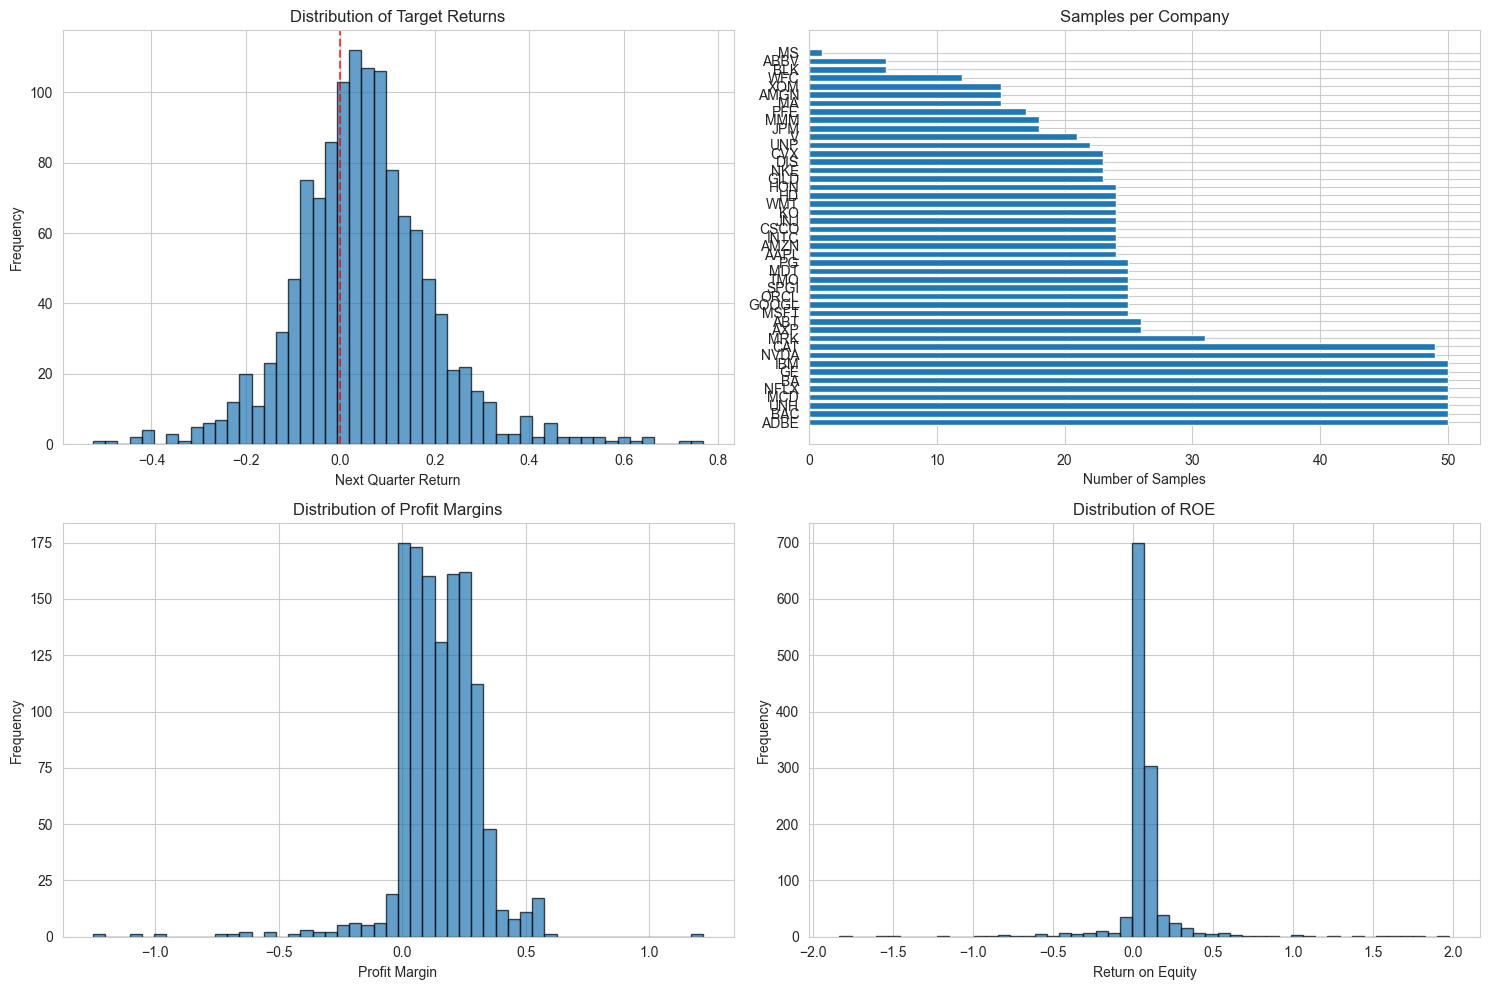

Saved visualization to results/data_exploration.png


In [12]:
# Cell 6: Data Exploration
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Target return distribution
axes[0, 0].hist(dataset['target_return'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Next Quarter Return')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Target Returns')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 2. Samples per company
samples_per_company = dataset['ticker'].value_counts()
axes[0, 1].barh(samples_per_company.index, samples_per_company.values)
axes[0, 1].set_xlabel('Number of Samples')
axes[0, 1].set_title('Samples per Company')

# 3. Profit margin distribution
axes[1, 0].hist(dataset['profit_margin'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Profit Margin')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Profit Margins')

# 4. ROE distribution
roe_clean = dataset['roe'][dataset['roe'].between(-2, 2)]
axes[1, 1].hist(roe_clean, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Return on Equity')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of ROE')

plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'data_exploration.png'), dpi=150, bbox_inches='tight')
plt.show()

print('Saved visualization to results/data_exploration.png')